In [227]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [167]:
data_raw = pd.read_csv('nshap_w1_w2_w3_core_disposition.csv',
                       low_memory=False)

## Data cleaning

In [190]:
# Since the data contains original cohort and follow-up cohort, we need to filter out the follow-up cohort
print("Total observations: {}".format(len(data_raw)))
data_w1 = data_raw[~data_raw['w1WEIGHT_ADJ'].isnull()]
print("Removed follow-up {} respondents without W1 observations".format(len(data_raw) - len(data_w1)))
data_decease= data_w1[data_w1.notnull()].copy()
data_decease['deceased'] = data_decease['w3DECEASED']
data_decease[data_decease['deceased'] == 'Unknown'] = np.nan
data_decease['deceased'].fillna(data_decease['w2DECEASED'], inplace=True)
data_decease[data_decease['deceased'] == 'Unknown'] = np.nan
data_complete = data_decease[data_decease['deceased'].notnull()]
print("Removed follow-up {} respondents without disposition statuses".format(len(data_w1) - len(data_complete)))
print("Sample frame has {} respondents".format(len(data_complete)))
# data_w3_missing = data_w1.iloc[(data_w1['w3DECEASED'] == 'Unknown').values]
# data_w3_missing = data_w3_missing.assign(deceased=data_w3_missing['w2DECEASED'])
# data_w3_nona = data_w1[(data_w1['w3DECEASED'] != 'Unknown').values]
# data_w3_nona = data_w3_nona.assign(deceased=data_w3_nona['w3DECEASED'])
# data_complete = pd.concat([data_w3_missing, data_w3_nona])

Total observations: 6069
Removed follow-up 3064 respondents without W1 observations
Removed follow-up 50 respondents without disposition statuses
Sample frame has 2955 respondents


In [191]:
data_complete['deceased'].value_counts()

Alive       2062
Deceased     893
Unknown        0
Name: deceased, dtype: int64

In [229]:
data = data_complete[['ID','deceased', 'w1AGE', 'w1SYSTOLIC_MEAN',
                      'w1BMI', 'w1HBA1C', 'w1CRP', 'w1DHEA_1', 'w1DHEA_2',
                      'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT',
                      'w1EDUC', 'w1HSASSETS_RECODE', 'w1MARITLST',
                      'w1PHYSHLTH', 'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK']]


In [230]:
cat_col = ['ID', 'deceased', 'w1ALCOHOL', 'w1HSASSETS_RECODE', 'w1MARITLST', 
           'w1CONDITNS_3', 'w1WALKBLK', 'w1SMOKECIG', 'w1EDUC',
           'w1PHYSACT', 'w1PHYSHLTH', 'w1MNTLHLTH']
data_cat = data[data[cat_col].notnull()].copy()[cat_col]    
for col in cat_col:
    data_cat[col] = data_cat[col].astype('category')

In [231]:
ord_col = ['w1AGE', 'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C', 
           'w1CRP', 'w1DHEA_1', 'w1DHEA_2']
data_ord = data[data[ord_col].notnull()].copy()[ord_col]    
for col in ord_col:
    data_ord[col] = pd.to_numeric(data_ord[col], errors='coerce')
data_ord['w1dhea_mean'] = data_ord[['w1DHEA_1', 'w1DHEA_2']].mean(axis=1)
data_ord = data_ord.drop(['w1DHEA_1', 'w1DHEA_2'], axis=1)
data_ord[data_ord < 0] = np.nan
data_ord.describe()

,w1AGE,w1SYSTOLIC_MEAN,w1BMI,w1HBA1C,w1CRP,w1dhea_mean
count,2955.000000,2885.000000,2742.000000,1723.000000,1912.000000,2358.000000
mean,69.314382,137.111496,29.106261,6.098665,3.190121,53.440017
std,7.864177,20.488770,6.286749,1.029052,6.043655,123.756165
min,57.000000,78.000000,14.063041,4.200000,0.000000,2.000000
25%,62.000000,122.500000,24.870780,5.500000,0.635750,18.691250
50%,69.000000,135.000000,28.241293,5.800000,1.537500,35.255000
75%,76.000000,149.500000,32.141636,6.300000,3.520500,64.913749
max,85.000000,233.000000,75.600655,14.200000,100.000000,5000.000000


In [232]:
data = pd.concat([data_cat, data_ord], axis=1)

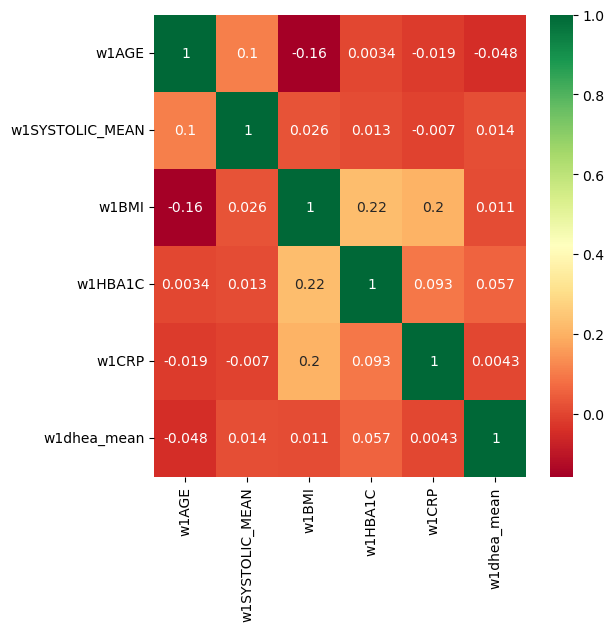

In [236]:
_, ax = plt.subplots(figsize=(6,6))
columns = ['w1AGE', 'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C', 
           'w1CRP', 'w1dhea_mean']
sns.heatmap(data[columns].corr(),annot=True,cmap='RdYlGn', ax=ax);